## Estimate Posterior using MCMC
study group tutorial 16jan19 / jplewis

source is in D/Julia/Learning, not Notes/Notebooks

In [25]:
using PyPlot
p_ = PyPlot

PyPlot

### test out Distributions package

In [26]:
using Distributions
noisesigma = 0.1
noise = Distributions.Normal(0., noisesigma)
gaussian(val,μ,σ) = (1. /sqrt(2. * π * σ^2 )) * exp( - (val-μ)^2 / (2. * σ^2))
(gaussian(2.3,0,noisesigma), Distributions.pdf(noise,2.3))
(gaussian(-0.3,0,noisesigma), Distributions.pdf(noise,-0.3))   # same

(0.044318484119380115, 0.044318484119380115)

### model

A,B ~ N(0,1)

$y = A x + B + \epsilon$

### true parameter values

In [27]:
N = 5  # data points
A = randn()
B = randn()
(A,B)

(-0.7191467449513858, 0.9302788905521097)

### Generate sample data

In [28]:
ϵ = noisesigma * randn(N,)   # todo use Distributions package sample
x = 2. * randn(N,)
y = A * x .+ B .+ ϵ

5-element Array{Float64,1}:
 -0.05946104455289588
  1.852839507445212  
 -0.21974229108137555
  2.264538548242975  
  1.8336210286697665 

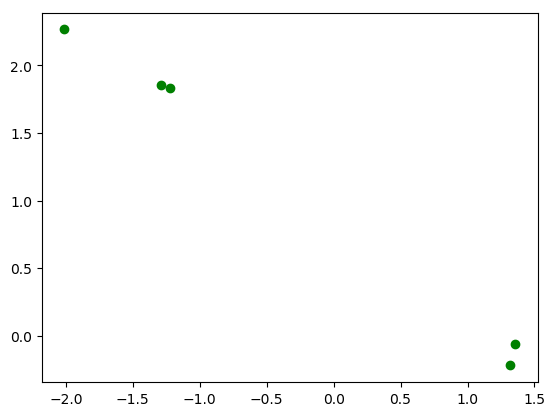

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13c9c7748>

In [29]:
p_.plot(x,y,"go")

### Note likelihood (and improper prior) cancel
General Bayes thm:

$$
    p(M|D) = \frac{ p(D|M) p(M)   }{ p(D)  } = \frac{ p(D|M) p(M)   }{ \int p(D|M) p(M) \, dM   }
$$

For the case of regression:

\begin{align*}
P(\theta|y,x) &= \frac{P(\theta,y,x)}{ P(y,x) }
\\
    &= \frac{ P(y|x,\theta) P(x|\theta) P(\theta) }{ P(y|x) P(x)  }
\\
    P(x|\theta) = P(x) \quad\text{and cancel}  &
\\
    &=  \frac{ P(y|x,\theta) P(\theta) }{ P(y|x) }
\\
\end{align*}

Posterior odds

\begin{align*}
   \frac{ P(\theta_1|y,x) }{ P(\theta|y,x) } &=   \frac{ \frac{ P(y|x,\theta_1) P(\theta_1) }{ P(y|x) } }{ \frac{ P(y|x,\theta) P(\theta) }{ P(y|x) } }     \quad=\quad  \frac{ P(y|x,\theta_1) P(\theta_1) }{  P(y|x,\theta) P(\theta)  }
\end{align*}

For the case of Gaussian noise $\epsilon$

$$
P(y|x,\theta) = \prod \frac{1}{\sqrt{ 2 \pi \sigma^2}} \exp(- \frac{1}{2}|y_i - (a x_i + b)|^2 / \sigma^2) 
$$

log likelihood = 

$$ 
-\frac{N}{2}\log(2 \pi \sigma^2) \quad-\quad  \left( \sum |y_i - (a x_i + b)|^2 / (2\sigma^2) \right) 
$$

(details)

\begin{align*}
&   \log \frac{1}{\sqrt{2 \pi \sigma^2}}
\\
&= \log 1  - \log ( 2 \pi \sigma^2 )^{1/2}
 \\
&=   0  - \frac{1}{2} \log{ 2 \pi \sigma^2}
\end{align*}

In [30]:
function loglikelihood(a,b)
    noisesigma2 = noisesigma*noisesigma
    ll = 0.
    for ipt = 1:N
        #print("  datapoint $ipt ")
        err = y[ipt] - (a*x[ipt]+b)
        peval = err*err / (2*noisesigma2)
        #print(" p0eval=",peval)
        ll -= peval
    end 
    ll -= (N/2.)*log(2*π*noisesigma2)
    ll
end

loglikelihood (generic function with 1 method)

In [31]:
normal = Distributions.Normal(0., 1.0 )
function logposterior(a,b)
    useprior = false   # else improper/flat prior
    prior = 0.
    if useprior
        prior += log(Distributions.pdf(normal,a))
        prior += log(Distributions.pdf(normal,b))
    end
    prior + loglikelihood(a,b)
end

logposterior (generic function with 1 method)

Stopping test, log version

$$
\frac{ \exp(n)}{\exp(d)} > 1  \quad\rightarrow\quad   n - d > 0 
$$

In [32]:
function mcmc1logposterior(a,b)
    println("mcmc1logposterior initial $a $b")
    
    logposterior0 = logposterior(a,b)
    
    for mciter = 1:100
        if ((mciter%10)==0) println("  mciter $mciter")  end
        a_ = a + 0.5 * randn()
        b_ = b + 0.5 * randn()       # new proposal
        
        logposterior1 = logposterior(a_,b_)
        
        #println("logp1 $logposterior1,   logp0 $logposterior0")

        p = exp(logposterior1) / exp(logposterior0)
        if (rand() < p)
            println("\nsuccess $a_, $b_")
            return (a_,b_)
        else
            print(".")
        end   
    end
    println("")
    return (a,b)
end

mcmc1logposterior (generic function with 1 method)

In [33]:
function warmup(a,b) 
    for iter = 1:1000 
        if ((iter%10)==0) println("iter $iter")  end
        a,b = mcmc1logposterior(a,b)   
    end
    return (a,b)
end                # warmup


warmup (generic function with 1 method)

In [34]:
function mcmcline(a,b)
    aavg, bavg = (0.,0.)
    Niter = 100000
    for iter = 1:Niter 
        if ((iter%10)==0) println("iter $iter")  end
        a,b = mcmc1logposterior(a,b)   
        aavg += a
        bavg += b
    end
    aavg /= float(Niter)
    bavg /= float(Niter)
    return (aavg,bavg)
end

mcmcline (generic function with 1 method)

In [35]:
# initial posterior estimate
a_, b_ = 0.,0.

a_, b_ = warmup(a_,b_)
aest, best = mcmcline(a_,b_)

print("estimate $aest, $best,   true $A, $B")

mcmc1logposterior initial 0.0 0.0

success -1.276022164380991, -0.5915364295798
mcmc1logposterior initial -1.276022164380991 -0.5915364295798

success -0.9660638929002373, -0.42052484262336265
mcmc1logposterior initial -0.9660638929002373 -0.42052484262336265
.......
success -0.4938753230162247, 0.0708411245627697
mcmc1logposterior initial -0.4938753230162247 0.0708411245627697

success -0.6103393565015721, 0.5219473432964847
mcmc1logposterior initial -0.6103393565015721 0.5219473432964847
..
success -1.004026956081482, 0.6170175389804908
mcmc1logposterior initial -1.004026956081482 0.6170175389804908
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..
success -0.8850237780365745, 0.8115969112618273
mcmc1logposterior initial -0.8850237780365745 0.8115969112618273
.
success -0.8259315400645474, 0.8840878945291633
mcmc1logposterior initial -0.8259315400645474 0.8840878945291633
.........  mciter 10
..........  mciter 20
.
success -0.7522715137252918,

success -0.819854950477, 0.9626734403865521
mcmc1logposterior initial -0.819854950477 0.9626734403865521
.........  mciter 10
..........  mciter 20
..........  mciter 30
.
success -0.6668142664755525, 0.8544463250899342
mcmc1logposterior initial -0.6668142664755525 0.8544463250899342
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..
success -0.8021789170455985, 0.780766496170596
mcmc1logposterior initial -0.8021789170455985 0.780766496170596
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 50
mcmc1logposterior initial -0.8021789170455985 0.780766496170596
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.....
success -0.6936709683989946, 0.9525602595543687
mcmc1logposterior initial -0.693670

success -0.6714878883498311, 0.8765636287730931
mcmc1logposterior initial -0.6714878883498311 0.8765636287730931
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6714878883498311 0.8765636287730931
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
.......
success -0.7133367924370787, 0.7768154640701648
mcmc1logposterior initial -0.7133367924370787 0.7768154640701648
.........  mciter 10
..........  mciter 20

success -0.7276796259897269, 1.0002791461726712
mcmc1logposterior initial -0.7276796259897269 1.0002791461726712
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.........
succes

..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7387433633269275 0.8440063361459473
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7387433633269275 0.8440063361459473
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7387433633269275 0.8440063361459473
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7387433633269275 0.

success -0.7533490176983634, 0.8490595215870744
mcmc1logposterior initial -0.7533490176983634 0.8490595215870744
.........  mciter 10
........
success -0.8240421385315347, 0.8519568151823738
mcmc1logposterior initial -0.8240421385315347 0.8519568151823738
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 200
mcmc1logposterior initial -0.8240421385315347 0.8519568151823738
.........  mciter 10
.....
success -0.8032419131733488, 0.881405117644091
mcmc1logposterior initial -0.8032419131733488 0.881405117644091
.........  mciter 10
.........
success -0.7476428350178717, 0.8385319539730766
mcmc1logposterior initial -0.7476428350178717 0.8385319539730766
.........  mciter 10
..........  mciter 20
..........  mciter 30
......
success -0.6793577701481858, 0.8636317615736604
mcmc1logposterior initial -0.6793577701481858 

success -0.8240605822460108, 0.8716186207461629
mcmc1logposterior initial -0.8240605822460108 0.8716186207461629
.........  mciter 10
.....
success -0.6855292767402232, 0.900512581876052
mcmc1logposterior initial -0.6855292767402232 0.900512581876052
....
success -0.6852678064584525, 0.8426567625616377
mcmc1logposterior initial -0.6852678064584525 0.8426567625616377
.........  mciter 10
......
success -0.6901233153804888, 0.8827704656037889
mcmc1logposterior initial -0.6901233153804888 0.8827704656037889
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
........
success -0.7086918605998118, 0.9375831433291334
mcmc1logposterior initial -0.7086918605998118 0.9375831433291334
.........  mciter 10
..........  mciter 20
..........  mciter 30
..
success -0.7435188864424018, 0.8101110285606388
iter 270
mcmc1logposterior initial -0.7435188864424018 0.8101110285606388
...

..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 310
mcmc1logposterior initial -0.6859500110867819 0.885559975468157
.......
success -0.728501749739962, 0.816013294866885
mcmc1logposterior initial -0.728501749739962 0.816013294866885
.........  mciter 10
..........  mciter 20
..........  mciter 30
..
success -0.7435398642424427, 0.8343060034164823
mcmc1logposterior initial -0.7435398642424427 0.8343060034164823
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7435398642424427 0.8343060034164823
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........

mcmc1logposterior initial -0.7835529706794402 0.9084842038946446
..
success -0.7764350826091085, 0.7726798559951298
mcmc1logposterior initial -0.7764350826091085 0.7726798559951298
.........  mciter 10
..
success -0.7329931140589919, 0.9249582966809358
mcmc1logposterior initial -0.7329931140589919 0.9249582966809358
.........  mciter 10
......
success -0.7378509567772823, 0.8631319257554724
mcmc1logposterior initial -0.7378509567772823 0.8631319257554724
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7378509567772823 0.8631319257554724
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.737

......
success -0.754975899453067, 0.7736434594233645
mcmc1logposterior initial -0.754975899453067 0.7736434594233645
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.754975899453067 0.7736434594233645
.........  mciter 10
......
success -0.7060243990043308, 0.8119917198787904
mcmc1logposterior initial -0.7060243990043308 0.8119917198787904
........
success -0.7206905470319955, 0.8104383169070773
iter 430
mcmc1logposterior initial -0.7206905470319955 0.8104383169070773
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
...
success -0.7185543938480297, 0.8807168052657512
mcmc1logposterior initial -0.7185543938480297 0.8807168052657512
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
.......... 

..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.684001155052077 0.8893539417527865
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..
success -0.7504476543821504, 0.9120349763713668
iter 500
mcmc1logposterior initial -0.7504476543821504 0.9120349763713668
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
.........
success -0.7336978971195495, 0.8119110547017155
mcmc1logposterior initial -0.7336978971195495 0.8119110547017155
.........  mciter 10
..........  mciter 20
..........  mciter 30
..
success -0.7108849740634214, 0.7816740504880084
mcmc1logposterior initial -0.7108849740634214 0.7816740504880084
...
success -0.8295920780665201, 0.7802295616510271
mcmc1logposterior initial -0.8295920

..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
...
success -0.7079739223147947, 0.7862197048876959
mcmc1logposterior initial -0.7079739223147947 0.7862197048876959
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7079739223147947 0.7862197048876959
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.....
success -0.7299634393185181, 0.7820978423642182
mcmc1logposterior initial -0.7299634393185181 0.7820978423642182
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.
success -0.8228532875448733, 0.7975676856270089
mcmc1logposterior initial -0.8228532875448733 0.7975676856270089
.........  m

mcmc1logposterior initial -0.733870385688135 0.7091064303916581
.........  mciter 10
..
success -0.7181092055297928, 0.9459153729780251
mcmc1logposterior initial -0.7181092055297928 0.9459153729780251
....
success -0.7441048051261323, 0.98007479380348
mcmc1logposterior initial -0.7441048051261323 0.98007479380348
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
.
success -0.8333432796629029, 0.8453193034254548
mcmc1logposterior initial -0.8333432796629029 0.8453193034254548
.....
success -0.6745981353438976, 0.7720662555068312
mcmc1logposterior initial -0.6745981353438976 0.7720662555068312
.........  mciter 10
.....
success -0.7820939194447485, 0.8561943855937584
mcmc1logposterior initial -0.7820939194447485 0.8561943855937584
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
.....

..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.762419928974183 0.9170000542851181
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 670
mcmc1logposterior initial -0.762419928974183 0.9170000542851181
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
....
success -0.7174051014635147, 0.9331965006836296
mcmc1logposterior initial -0.7174051014635147 0.9331965006836296
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mcit

mcmc1logposterior initial -0.6918480996442271 0.8113849077115293
.........  mciter 10

success -0.7417338701870666, 0.8310948817888384
mcmc1logposterior initial -0.7417338701870666 0.8310948817888384
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7417338701870666 0.8310948817888384
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7417338701870666 0.8310948817888384
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc

.........
success -0.7791281034212729, 0.8464625833258118
mcmc1logposterior initial -0.7791281034212729 0.8464625833258118
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7791281034212729 0.8464625833258118
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80

success -0.695536473159173, 0.8591521267544772
iter 780
mcmc1logposterior initial -0.695536473159173 0.8591521267544772
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.695536473159173 0.8591521267544772
........

..........  mciter 30
..........  mciter 40
..........  mciter 50
......
success -0.7129122683711843, 0.876172857361014
mcmc1logposterior initial -0.7129122683711843 0.876172857361014
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7129122683711843 0.876172857361014
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
...
success -0.717657705892631, 0.9134999001026572
mcmc1logposterior initial -0.717657705892631 0.9134999001026572
...
success -0.7411536161659839, 0.8450154102412543
iter 830
mcmc1logposterior initial -0.7411536161659839 0.8450154102412543
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
.....

mcmc1logposterior initial -0.7635246557489468 0.8351515154303791
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7635246557489468 0.8351515154303791
.........  mciter 10
..........  mciter 20
..........  mciter 30
......
success -0.7004577590436076, 0.7970985312145482
mcmc1logposterior initial -0.7004577590436076 0.7970985312145482
.........  mciter 10
..........  mciter 20
..........  mciter 30
...
success -0.7795041514899047, 0.8710634082592499
mcmc1logposterior initial -0.7795041514899047 0.8710634082592499
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7795041514899047 0.87106340825

..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7614362041305291 0.8455705465765875
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7614362041305291 0.8455705465765875
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7614362041305291 0.8455705465765875
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7614362041305291 0.

mcmc1logposterior initial -0.7550504683942636 0.8945686357635373
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7550504683942636 0.8945686357635373
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70

success -0.7397543224239054, 0.753953143223872
iter 980
mcmc1logposterior initial -0.7397543224239054 0.753953143223872
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7397543224239054 0.753953143223872
.........  mciter 10
..........  mciter 20
..........  mciter 30
.......
success -0.7311

.
mcmc1logposterior initial -0.7069948844786452 0.8715490682899455
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7069948844786452 0.8715490682899455
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7069948844786452 0.8715490682899455
.........  mciter 10
..........  mciter 20
...
success -0.7547049133240884, 0.8606092004701752
mcmc1logposterior initial -0.7547049133240884 0.8606092004701752
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..

..........  mciter 100
.
mcmc1logposterior initial -0.7588997954691625 0.8434372619222124
....
success -0.7474765472353927, 0.8325800445306027
iter 90
mcmc1logposterior initial -0.7474765472353927 0.8325800445306027
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7474765472353927 0.8325800445306027
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7474765472353927 0.8325800445306027
.........  mciter 10
....
success -0.7822762884436731, 0.9041877890431835
mcmc1logposterior initial -0.7822762884436731 0.9041877890431835
.........  mciter 10
..........  mciter 20
..........  mciter 30
......

mcmc1logposterior initial -0.7509628641159688 0.8654211532342334
.........  mciter 10
..........  mciter 20
.
success -0.7390851167847736, 0.8114670460791026
mcmc1logposterior initial -0.7390851167847736 0.8114670460791026
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50

success -0.7331525149891726, 0.8450821418273263
iter 170
mcmc1logposterior initial -0.7331525149891726 0.8450821418273263
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
.........
success -0.7272238053932197, 0.8663605776504544
mcmc1logposterior initial -0.7272238053932197 0.8663605776504544
...
success -0.7443256897524165, 0.8863321661689596
mcmc1logposterior initial -0.7443256897524165 0.8863321661689596
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70

..
success -0.7467318297230999, 0.9272148036308008
mcmc1logposterior initial -0.7467318297230999 0.9272148036308008
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
....
success -0.7407426730408552, 0.8816398526535789
mcmc1logposterior initial -0.7407426730408552 0.8816398526535789
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7407426730408552 0.8816398526535789
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7407426730408552 0.8816398526535789
.........  mciter

.........  mciter 10
..........  mciter 20
......
success -0.6978341040284304, 0.9782507146019782
mcmc1logposterior initial -0.6978341040284304 0.9782507146019782
.........  mciter 10
..........  mciter 20
..
success -0.6900170640560631, 0.8129394419275691
mcmc1logposterior initial -0.6900170640560631 0.8129394419275691
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
......
success -0.7300644403405738, 0.8136038889264733
mcmc1logposterior initial -0.7300644403405738 0.8136038889264733
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 250
mcmc1logposterior initial -0.7300644403405738 0.8136038889264733
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60


..........  mciter 60
.......
success -0.7023542950486421, 0.9138439232427555
mcmc1logposterior initial -0.7023542950486421 0.9138439232427555
.........  mciter 10
......
success -0.6832224715633827, 0.8968221606408618
mcmc1logposterior initial -0.6832224715633827 0.8968221606408618
.........  mciter 10
..........  mciter 20
.....
success -0.7040111674473094, 0.9309860337596007
mcmc1logposterior initial -0.7040111674473094 0.9309860337596007
.........  mciter 10
..........  mciter 20
.
success -0.7112130589759547, 0.8806428419491336
mcmc1logposterior initial -0.7112130589759547 0.8806428419491336
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50

success -0.6863762472444351, 0.8889159892623697
mcmc1logposterior initial -0.6863762472444351 0.8889159892623697
.....
success -0.7878222639921169, 0.8579611352291836
mcmc1logposterior initial -0.7878222639921169 0.8579611352291836
.........  mciter 10
..........  mciter 20
.......... 

..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7166876524505335 0.860335961191443
.........  mciter 10
.....
success -0.7675453847586656, 0.8073818620836997
mcmc1logposterior initial -0.7675453847586656 0.8073818620836997
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.......
success -0.7279107908941445, 0.869767689639882
iter 340
mcmc1logposterior initial -0.7279107908941445 0.869767689639882
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7279107908941445 0.869767689639882
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
.....
s

..........  mciter 20
.......
success -0.689577589280375, 0.9318168427623837
mcmc1logposterior initial -0.689577589280375 0.9318168427623837
.........  mciter 10
..........  mciter 20
.......
success -0.7996600126753111, 0.8326914209637462
mcmc1logposterior initial -0.7996600126753111 0.8326914209637462
..
success -0.7566559482822544, 0.9238395590705574
mcmc1logposterior initial -0.7566559482822544 0.9238395590705574
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7566559482822544 0.9238395590705574
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7566559482822544 0.9238395590705574
.....

mcmc1logposterior initial -0.7488235876740502 0.8598582611250368
.......
success -0.731615971202599, 0.8104543262874488
mcmc1logposterior initial -0.731615971202599 0.8104543262874488
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.731615971202599 0.8104543262874488
.........  mciter 10
....
success -0.7295262866589715, 0.8272550947131959
mcmc1logposterior initial -0.7295262866589715 0.8272550947131959
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
........
success -0.7150615171477588, 0.8985854976280251
mcmc1logposterior initial -0.7150615171477588 0.8985854976280251
.........  mciter 10
..........  mciter 20
..........  mciter 30
..
success -0.717653070495508, 0.8043981961846062
mcmc1logposterior initial -0.717653070495508 0.8043981961846062
...

mcmc1logposterior initial -0.6966809363166508 0.8722109424265635
...
success -0.7487135069689663, 0.7958872959320781
mcmc1logposterior initial -0.7487135069689663 0.7958872959320781
.........  mciter 10
..........  mciter 20
........
success -0.6753944297475921, 0.909107584682632
mcmc1logposterior initial -0.6753944297475921 0.909107584682632
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
........
success -0.7045920897661546, 0.8811413791525878
mcmc1logposterior initial -0.7045920897661546 0.8811413791525878
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7045920897661546 0.8811413791525878
....
success -0.7049580106238327, 0.8549412426230129
mcmc1logposterior initial -0.7049580106238327 0.8549412426230129
.........  mciter 1

mcmc1logposterior initial -0.7340159999755299 0.7789820736498203
.........  mciter 10
....
success -0.6937259934774953, 0.9124996176364151
mcmc1logposterior initial -0.6937259934774953 0.9124996176364151
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6937259934774953 0.9124996176364151
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.6937259934774953 0.9124996176364151
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
.
success -0.751742735706548, 0.936062920311497

..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7054345523317347 0.8747681913796176
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7054345523317347 0.8747681913796176
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7054345523317347 0.8747681913796176
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
...
success -0.7084920915641422, 0.9100729363393844
mcmc1logposterior ini

mcmc1logposterior initial -0.7748708337606546 0.912593445889862
.........  mciter 10
.....
success -0.7067786793549363, 0.7827947425101829
mcmc1logposterior initial -0.7067786793549363 0.7827947425101829
.........  mciter 10
...
success -0.6591315328799913, 0.8333546611467746
mcmc1logposterior initial -0.6591315328799913 0.8333546611467746
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
.......
success -0.7101821579236539, 0.8687644917986925
mcmc1logposterior initial -0.7101821579236539 0.8687644917986925
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
...
success -0.8019058820289579, 0.9271438468928092
iter 660
mcmc1logposterior initial -0.8019058820289579 0.9271438468928092
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
......
success -0.6902454829632056, 0.8396374563169392
mcmc1lo

..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.8062555879144149 0.8277156084686155
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.8062555879144149 0.8277156084686155
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40

success -0.72933522840292, 0.7867094867335527
mcmc1logposterior initial -0.72933522840292 0.7867094867335527
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
....
success -0.7683396668194191, 0.9165840534858345
mcmc1logposterior initial -0.7683396668194191 0.9165840534858345
.........  mciter 10
..........  mciter 20
..........  mciter 30
..

..........  mciter 80
..........  mciter 90
...
success -0.7391595315548907, 0.855905396343661
mcmc1logposterior initial -0.7391595315548907 0.855905396343661
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
.....
success -0.7851918794069791, 0.8728190739216384
mcmc1logposterior initial -0.7851918794069791 0.8728190739216384
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
....
success -0.787962587466044, 0.9264527162567253
mcmc1logposterior initial -0.787962587466044 0.9264527162567253
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
.........
success -0.7820486073954086, 0.9486362861488545
iter 740
mcmc1logposterior initial -0.7820486073954086 0.9486362861488545
....
success -0.6491771211721846, 0.9111496731967638
mcmc1l

..........  mciter 40
..........  mciter 50
..
success -0.7511248543158172, 0.8082745771980875
mcmc1logposterior initial -0.7511248543158172 0.8082745771980875
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7511248543158172 0.8082745771980875
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7511248543158172 0.8082745771980875
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.......
success -0.7411863350141715, 0.9094054627656559
mcmc1logposterior initial -0.7411863350141715 0.9094054627656559
.........  mci

..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..
success -0.7348210189150307, 0.9515921295473948
mcmc1logposterior initial -0.7348210189150307 0.9515921295473948
..
success -0.6994177143009986, 0.8259055998138424
mcmc1logposterior initial -0.6994177143009986 0.8259055998138424
.........  mciter 10
.........
success -0.7054223204189038, 0.8048137536379977
mcmc1logposterior initial -0.7054223204189038 0.8048137536379977
.........  mciter 10
..........  mciter 20
..........  mciter 30
..
success -0.7080882471811104, 0.8308011393207221
mcmc1logposterior initial -0.7080882471811104 0.8308011393207221
.........  mciter 10

success -0.6755633377260816, 0.9101765508444231
mcmc1logposterior initial -0.6755633377260816 0.9101765508444231
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100


..........  mciter 20
..........  mciter 30
..
success -0.7252910743001617, 0.8840743458340985
mcmc1logposterior initial -0.7252910743001617 0.8840743458340985
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7252910743001617 0.8840743458340985
........
success -0.717375245854275, 0.8695709694563536
mcmc1logposterior initial -0.717375245854275 0.8695709694563536
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
iter 880
mcmc1logposterior initial -0.717375245854275 0.8695709694563536
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.......

.
mcmc1logposterior initial -0.7527207667468128 0.8498386222971915
.........  mciter 10
..........  mciter 20
.
success -0.7468449829227066, 0.8934130271474776
iter 930
mcmc1logposterior initial -0.7468449829227066 0.8934130271474776
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7468449829227066 0.8934130271474776
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7468449829227066 0.8934130271474776
.........  mciter 10
.........
success -0.7693870840596686, 0.765429805335675
mcmc1logposterior initial -0.7693870840596686 0.765429805335675
.........  mciter 10
...
success -0.77294823336447

..........  mciter 70
..........  mciter 80
......
success -0.7959309938612279, 0.7870541469184683
mcmc1logposterior initial -0.7959309938612279 0.7870541469184683
.........  mciter 10
..........  mciter 20
.
success -0.7586035342166583, 0.7895112881616226
mcmc1logposterior initial -0.7586035342166583 0.7895112881616226
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100

success -0.7154773821120763, 0.8326668400214183
mcmc1logposterior initial -0.7154773821120763 0.8326668400214183
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.
success -0.6515246688345324, 0.9136679284242486
mcmc1logposterior initial -0.6515246688345324 0.9136679284242486
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
.......... 

..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.770597369910576 0.9730255056072229
.........  mciter 10
........
success -0.7119894388263092, 0.8586213468280344
mcmc1logposterior initial -0.7119894388263092 0.8586213468280344
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
.
success -0.7297709489548677, 0.9433584173217089
mcmc1logposterior initial -0.7297709489548677 0.9433584173217089
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7297709489548677 0.9433584173217089
.........  mciter 10
..........  mciter 20
..........  mciter 30
.....
success -0.7048820767685108, 0.9595050930308872
iter 1020
mcmc1logposterior initial -0.7048820767685108 0.95950509303088

..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7347505336737146 0.8400678064024053
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7347505336737146 0.8400678064024053
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7347505336737146 0.8400678064024053
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
.......

success -0.7923760781565653, 0.8495013654569828
mcmc1logposterior initial -0.7923760781565653 0.8495013654569828
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
...
success -0.7905879861800899, 0.8170735842263083
mcmc1logposterior initial -0.7905879861800899 0.8170735842263083
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
....
success -0.7668439320864152, 0.8434825021871216
mcmc1logposterior initial -0.7668439320864152 0.8434825021871216
.........  mciter 10
..........  mciter 20
..........  mciter 30
.....
success -0.6650180238374263, 0.916826270499749
mcmc1logposterior initial -0.6650180238374263 0.916826270499749
.........  mciter 10
..........  mciter 20
........
success -0.6853524331492726, 0.8151215241474635
iter 1110
mcmc1logposterior initial -0.6853524331492726 0.8151215241474635
.........  mciter 10
..........  mciter 20
..........  

..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7410410155186535 0.8597817098841187
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7410410155186535 0.8597817098841187
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7410410155186535 0.8597817098841187
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
........
success -0.6884811640996596, 0.8572831806543809
mcmc1logposterio

..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.7633587216515056 0.907235727921843
.....
success -0.755641584087225, 0.8208723145896277
mcmc1logposterior initial -0.755641584087225 0.8208723145896277

success -0.703145433253583, 0.8472908312499084
mcmc1logposterior initial -0.703145433253583 0.8472908312499084
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
...
success -0.8201500372444118, 0.9626589465329884
mcmc1logposterior initial -0.8201500372444118 0.9626589465329884
.........  mciter 10
.....
success -0.8227360040265541, 0.9148425642072677
mcmc1logposterior initial -0.8227360040265541 0.9148425642072677
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
.
success -0.7566120114913106, 0.7873254672326552
iter 1220
mcmc1logposterior initial -0.75661201

Excessive output truncated after 524310 bytes.


mcmc1logposterior initial -0.7250308759098693 0.9415878587779573
.........  mciter 10
.....
success -0.775082722109533, 0.8583795441748732
mcmc1logposterior initial -0.775082722109533 0.8583795441748732
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.775082722109533 0.8583795441748732
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mcmc1logposterior initial -0.775082722109533 0.8583795441748732
.........  mciter 10
..........  mciter 20
..........  mciter 30
..........  mciter 40
..........  mciter 50
..........  mciter 60
..........  mciter 70
..........  mciter 80
..........  mciter 90
..........  mciter 100
.
mc

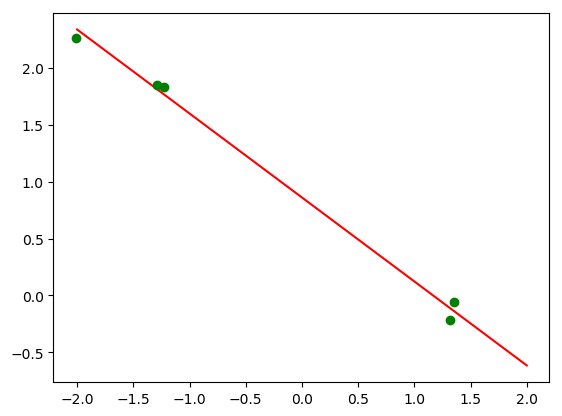

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13cb20828>

In [36]:
xx = [-2., 2.]
yy = aest .* xx .+ best
p_.plot(xx,yy,"r-")
p_.plot(x,y,"go")